In [1]:
import pandas as pd
import glob

file_names = glob.glob('./Production Data by Brewery by Month 2022-20240226T230240Z-001/Production Data by Brewery by Month 2022/*.pdf')

import docx
def getText(filename):
    # importing required modules 
    from pypdf import PdfReader 
    
    # creating a pdf reader object 
    reader = PdfReader(filename) 
    fullText = ""
    for page in reader.pages:
        fullText += page.extract_text() + '\n'
    return fullText 

import pandas as pd
contents = {}
for file_name in file_names:
    content = getText(file_name)
    contents[file_name] = content

In [2]:
# read in data that are four columns situated at certain positions
def checkLine(line):
    parts = line.strip('\n').replace(',', '').split()
    # check if have 3 float at the end of each line
    fCount = 0
    for i in range(len(parts) - 3, len(parts)):
        try:
            float(parts[i])
            fCount += 1
        except:
            pass
    try:
        assert(fCount == 3)
        name = ' '.join(parts[:-3])
        assert("Total" not in name)
        cond = True
    except:
        cond = False
    return cond

def formatLine(line):
    parts = line.strip('\n').replace(',', '').split()
    # check if have 3 float in each line
    fCount = 0
    for i in range(len(parts) - 3, len(parts)):
        try:
            float(parts[i])
            fCount += 1
        except:
            pass
    name = ' '.join(parts[:-3])
    return (name, float(parts[-3]), float(parts[-2]), float(parts[-1]))

import os

dataObject = {}
for file_name in file_names:
    month = os.path.basename(file_name)[:3].upper()
    lines = contents[file_name].split('\n')
    # concat lines that have brewery name split into two lines
    for i in range(len(lines) - 1):
        if (not checkLine(lines[i]) and ("BREWERY" in lines[i] or "COMPANY" in lines[i] or "CO." in lines[i])) and checkLine(lines[i + 1]):
            lines[i] = lines[i] + ' ' + lines[i + 1]
            lines[i + 1] = ''
    
    # also filter lines that are not in state
    for i in range(len(lines)):
        line = lines[i]
        if "Out of State Brewery Trade Name" in line:
            break
    lines = lines[:i]

    filtLines = list(filter(lambda text: checkLine(text), lines))

    data = list(map(lambda text: formatLine(text), filtLines))
    df = pd.DataFrame(data, columns=['Brewery', 'Over 60000', '60000 Under', 'Total'])

    # merge data with same brewery name
    df = df.groupby('Brewery').sum().reset_index()
    dataObject[month] = df

In [3]:
monthNumberObject = {
    "JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6, "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12
}

# aggregate data from different breweries into one dataframe
dfAll = pd.DataFrame(columns=['Brewery'])
for month in dataObject:
    df = dataObject[month]
    dfSub = df[['Brewery', 'Total']].rename(columns={'Total': monthNumberObject[month]})
    dfAll = pd.merge(dfAll, dfSub, on='Brewery', how='outer')

In [4]:
# sort breweries by total production
sortedDfAll = dfAll.iloc[dfAll[[1,2,3,4,5,6,7,8,9,10,11,12]].sum(axis=1).sort_values(ascending=False).index].reset_index(drop=True)
# drop row total production
sortedDfAll = sortedDfAll[sortedDfAll['Brewery'].apply(lambda x: "Total" not in x)].reset_index(drop=True)


In [5]:
sortedDfAll.to_csv('brewery_monthly_production_2022.csv', index=False, header=True)

In [6]:
sortedDfAll.head()

,Brewery,4,8,12,2,1,7,6,3,5,11,10,9
0,GEORGETOWN BREWING CO.,8672.18,10193.51,7380.14,6503.01,6409.97,8722.62,9571.99,8538.23,8855.93,9315.17,8985.20,9227.20
1,FREMONT BREWING,2536.74,2731.87,3229.78,2144.60,2466.78,2720.60,3077.69,2800.91,2616.72,2435.67,2050.42,2819.80
2,MAC & JACKS BREWERY INC.,2036.64,2412.73,1755.14,1841.37,1951.90,2052.96,2776.15,1780.41,2171.85,1902.20,2225.78,2378.33
3,REUBENS BREWS,2070.59,2617.09,1592.80,1676.63,1705.85,2303.87,2519.17,1933.15,2077.57,1709.33,1740.98,2433.18
4,BALE BREAKER BREWING COMPANY,1900.88,2282.84,1416.19,1276.72,1535.06,2302.83,2140.11,1822.97,1802.26,2088.51,1536.51,1709.75


In [7]:
# Create a new column 'total' that is the sum of all month columns
sortedDfAll['total'] = sortedDfAll.iloc[:, 1:].sum(axis=1)

# Group by 'Brewery', and find the row with the largest 'total' for each 'Brewery'
top_rows = sortedDfAll.loc[sortedDfAll.groupby("Brewery")["total"].idxmax()].sort_values(by='total', ascending=False).reset_index(drop=True)

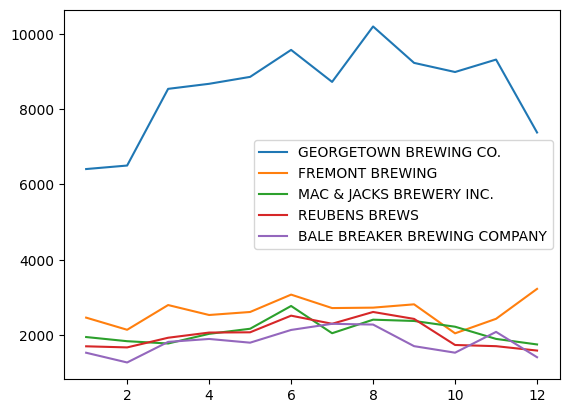

In [8]:
import matplotlib.pyplot as plt

# Assuming top_rows is a DataFrame where each row represents a brewery and columns 1-11 are the months
for index, row in top_rows.head(5).iterrows():
    plt.plot(row[[1,2,3,4,5,6,7,8,9,10,11,12]], label=top_rows.iloc[index].Brewery)

plt.legend()
plt.show()

In [9]:
breweries1 = sortedDfAll.Brewery.tolist()

In [10]:
wa_breweries_df = pd.read_csv("wa_breweries.csv")

In [11]:
breweries2 = wa_breweries_df.brewery.tolist()

In [12]:
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords

unnecessary_words = stopwords.words('english')

# Find the best match between the production data breweries and the WA breweries
matches = []
for brewery1 in breweries2:
    match = None
    match_score = 0
    brewery1 = brewery1.lower()
    for brewery2 in breweries1:
        brewery2 = brewery2.lower()
        # find the best match that has the most matched words
        score = 0
        for w1 in brewery1.split():
            for w2 in brewery2.split():
                if w1 == w2:
                    score += 1 * (0 if w1 in ["brewery", "brewing", "company", "co"] + unnecessary_words else 1)
        scoreFuzz = fuzz.ratio(brewery1, brewery2)
        if score > match_score and scoreFuzz > 50:
            match = brewery2
            match_score = score
    if match:
        matches.append((brewery1, match, match_score))

In [13]:
matches

[('192 brewing company', '192 brewing company', 1),
 ('192 brewing company', '192 brewing company', 1),
 ('20 corners brewing company', '20 corners brewing', 2),
 ('23rd ave brewery', '23rd ave brewery', 2),
 ('4 stitch brewing company', '4 stitch brewing co.', 2),
 ('5 north brewing company', '5 north brewing company', 2),
 ('5 rights brewing company', '5 rights brewing llc', 2),
 ('5th line brewing company', '5th line brewing co.', 2),
 ('7 seas brewing company', '7 seas brewing', 2),
 ('7 seas brewing company', '7 seas brewing', 2),
 ('acorn brewing', 'acorn brewing', 1),
 ('airways brewing company', 'airways brewing company', 1),
 ('airways brewing company', 'airways brewing company', 1),
 ('ale spike camano island brewing', 'bainbridge island brewing', 1),
 ('anacortes brewery', 'anacortes brewery', 1),
 ('ancient lakes brewing company', 'mountain lakes brewing company', 1),
 ('ashtown brewing company', 'ashtown brewing company', 1),
 ('aslan brewing company', 'aslan brewing compa

In [14]:
# after careful comparing the match results, we found that some matches are wrong 
wrong_matches = [('ancient lakes brewing company', 'mountain lakes brewing company', 1),

 ('bardic brewing and cider', 'tilted tree hard cider', 1),

 ('big barn brewing company', 'big time brewing company', 1),

 ('bosk brew works', 'northwest brewery works', 1),

 ('byron street brewery', 'perry street brewing company', 1),

 ('columbia valley brewing company', 'valley brewing company', 1),

 ('dog and pony brewing company', 'tin dog brewing', 1),

 ('dog days brewing', 'tin dog brewing', 1),

 ('high steel beer company', 'varietal beer company', 1),

 ('hops and seed brewing company', 'singing hops brewing company', 1),

 ('irrelevant beer', 'otherlands beer', 1),

 ('mcmenamins east vancouver brewery', 'mcmenamins anderson school', 1),

 ('mcmenamins mill creek brewery', 'mcmenamins elks temple brewery', 1),
 ('mcmenamins olympic club brewery', 'mcmenamins anderson school', 1),
 ('mcmenamins on the columbia brewery', 'mcmenamins anderson school', 1),
 ('mcmenamins queen anne brewery', 'mcmenamins anderson school', 1),
 ('mcmenamins six arms brewery', 'mcmenamins anderson school', 1),
 ('mcmenamins spar cafe brewery', 'mcmenamins anderson school', 1),

 ('northwest passage craft brewery', 'northwest brewery works', 1),

 ('skagit river brewing company', 'river city brewing', 1),

 ('snipes mountain brewing', 'holy mountain brewing company', 1),

 ('sound to summit brewing', 'north sound brewing co', 1),

 ('steam plant brewing company', 'steam donkey brewing company', 1),

 ('top down brewing company', 'top rung brewing company', 1),

 ('wild oak project', 'golden handle project s.p.c.', 1),

 ('logsdon farmhouse ales', 'spada farmhouse brewery', 1)
]

In [15]:
# prune the wrong matches
matches = [match for match in matches if match not in wrong_matches]

In [16]:
# find the breweries in wa breweries that are not matched
unmatched_breweries = [brewery for brewery in breweries2 if brewery.lower() not in [match[0].lower() for match in matches]]

In [17]:
should_match = { 
 'Bardic Brewing and Cider': "BARDIC BREWING",
 "Bennidito's Brewpub": "BENNIDITOS BREW PUB",
 "Blackbeard's Brewing Company": "BLACKBEARDS BREWING COMPANY",
 'Byron Street Brewery': "BYRON ST BREWERY",
 "Dick's Brewing Company": "DICKS BREWING COMPANY",
 'E9 Firehouse and Gastropub': "E9 BREWING CO",
 "Everybody's Brewing": "EVERYBODYS BREWING",
 'Off Camber Brewing': "OFF-CAMBER BREWING",
 'Sound To Summit Brewing': "SOUND2SUMMIT BREWERY",
 'Terramar Brewing and Distilling': "TERRAMAR",
 'Top Down Brewing Company': "TOP DOWN BREWING COMPANY",
 "Captain's Brewing Company": "CAPTAINS BREWING COMPANY",
 "Barlow's Brewery": "BARLOWS BREWERY",
 'Brewbakers Brewing Company': "BREW BAKERS",
 'No Boat Brewing Company': "NOBOAT BREWING COMPANY"
 }

In [18]:
# append the should match items along with matches and render the result
matches_object = dict(list(map(lambda tup: (tup[0].lower(), tup[1].lower()), matches)))
should_match_object = dict(list(map(lambda kv: (kv[0].lower(), kv[1].lower()) ,should_match.items())))
# concat both dictionaries
matches_object = {**matches_object, **should_match_object}

In [19]:
# this provides a mapping between the WA breweries list with the brewery_monthly_production_2022.csv
matches_object

{'192 brewing company': '192 brewing company',
 '20 corners brewing company': '20 corners brewing',
 '23rd ave brewery': '23rd ave brewery',
 '4 stitch brewing company': '4 stitch brewing co.',
 '5 north brewing company': '5 north brewing company',
 '5 rights brewing company': '5 rights brewing llc',
 '5th line brewing company': '5th line brewing co.',
 '7 seas brewing company': '7 seas brewing',
 'acorn brewing': 'acorn brewing',
 'airways brewing company': 'airways brewing company',
 'ale spike camano island brewing': 'bainbridge island brewing',
 'anacortes brewery': 'anacortes brewery',
 'ashtown brewing company': 'ashtown brewing company',
 'aslan brewing company': 'aslan brewing company',
 'at large brewing': 'at large brewing and taproom',
 'atomic ale brewpub and eatery': 'atomic ale brewpub & eatery',
 'atwood farm brewery': 'atwood ales',
 'audacity brewing': 'audacity brewing',
 'backwoods brewing company': 'backwoods brewing company',
 "bad jimmy's brewing company": 'bad ji

In [20]:
# this provides the missing breweries that are not in production data from WA breweries
missing_breweries = [brewery for brewery in unmatched_breweries if brewery not in should_match]
missing_breweries

['210 Brewing Company',
 "54°40' Brewing Company",
 'Ancient Lakes Brewing Company',
 'Big Barn Brewing Company',
 'Bluebird Microcreamery and Brewery',
 'Bosk Brew Works',
 'Columbia Valley Brewing Company',
 'Craft Brewing Academy/Skagit Valley College',
 'Crossbuck Brewing',
 'Dog and Pony Brewing Company',
 'Dog Days Brewing',
 'Dunagan Irish Pub and Brewery',
 'El Sueñito Brewing Company',
 'Ellensburg Brewery Company',
 'Ethereal Meads',
 'Exit 16 Brewing',
 'Forward Operating Base Brewing Company',
 'Fountain Brewing',
 'Halcyon Brewing',
 'High Steel Beer Company',
 'Hops and Seed Brewing Company',
 'Hopworks Urban Brewery',
 'Irrelevant Beer',
 'Larrabee Lager Company',
 'McMenamins East Vancouver Brewery',
 'McMenamins Mill Creek Brewery',
 'McMenamins Olympic Club Brewery',
 'McMenamins On the Columbia Brewery',
 'McMenamins Queen Anne Brewery',
 'McMenamins Six Arms Brewery',
 'McMenamins Spar Cafe Brewery',
 'Métier Brewing Company',
 'Northwest Passage Craft Brewery',
 'P